In [78]:
import sys
import pandas as pd
%matplotlib inline
import statsmodels
import plotly
import os

print(sys.version)
print("")
print(f"pandas:      version {pd.__version__}")
print(f"statsmodels: version {statsmodels.__version__}")
print(f"plotly:      version {plotly.__version__}")

3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]

pandas:      version 1.1.1
statsmodels: version 0.11.1
plotly:      version 4.10.0


In [2]:
new_york = pd.read_csv("../data/weather/new_york_ny.csv")

print(new_york.shape)
new_york.head()

(17056, 25)


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2009-01-01 00:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,38,22,62,0.0,1017,-6,10,316,27,10007
1,2009-01-01 06:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,33,7,63,0.0,1023,-8,10,315,24,10007
2,2009-01-01 12:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,26,4,42,0.0,1025,-3,10,304,23,10007
3,2009-01-01 18:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,21,16,49,0.0,1025,-5,10,294,13,10007
4,2009-01-02 00:00:00,0,0,0.1,7.0,2,38,11:28 AM,11:54 PM,08:20 AM,...,14,46,49,0.0,1023,-6,10,260,8,10007


In [3]:
new_york.columns

Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location'],
      dtype='object')

### Planning - Pre-modeling

**Accounting for Seasonal Variations**


- Create dynamic datetime splits separating the four seasons and taking the year as an input,
- Use these datetime splits to subset New York City's data by year and season into smaller DataFrames,
- Identify max, min, avg, and med of the following seasonal weather metrics (both metric and imperial because **AMERICA**):
    - tempC
    - FeelsLikeC, see above
    - totalSnow_cm  **<--**  if None, final app will return a verbal message saying it does not Snow there
    - humidity
    - pressure
    
- Store the above data in a single DataFrame and create visualizations for the annual progression of each


**NOTE:** Data will begin on the first day of Spring 2009 and be cut off on the last day of summer 2020 so as to account for potentally eroneous data arising from partial seasons. Go back and make this adjustment to the *weather.py* file.


**Applying the above process to all of the data**


- Encapsulate the above process in a function or functions,
- Devise means of applying the above function(s) to all csv files in the root data/weather directory,
- Organize and store yearly averages in a by_year DataFrame,
- Create visualizations showing how the average seasonal weather of each compares with the average of all,
- Encapsulate the above visualization process into a function for easy use.


**Testing that this process will function in Fast API in notebook**


- Replicate Ryan Herr's example notebook material for testing Fast API locally to this notebook.
- Test that the above visualization-making functions work locally.

In [4]:
new_york.dtypes

date_time             object
maxtempC               int64
mintempC               int64
totalSnow_cm         float64
sunHour              float64
uvIndex                int64
moon_illumination      int64
moonrise              object
moonset               object
sunrise               object
sunset                object
DewPointC              int64
FeelsLikeC             int64
HeatIndexC             int64
WindChillC             int64
WindGustKmph           int64
cloudcover             int64
humidity               int64
precipMM             float64
pressure               int64
tempC                  int64
visibility             int64
winddirDegree          int64
windspeedKmph          int64
location               int64
dtype: object

In [5]:
new_york.date_time

0        2009-01-01 00:00:00
1        2009-01-01 06:00:00
2        2009-01-01 12:00:00
3        2009-01-01 18:00:00
4        2009-01-02 00:00:00
                ...         
17051    2020-09-02 18:00:00
17052    2020-09-03 00:00:00
17053    2020-09-03 06:00:00
17054    2020-09-03 12:00:00
17055    2020-09-03 18:00:00
Name: date_time, Length: 17056, dtype: object

In [6]:
# Checking date_time format

date = new_york.date_time[0]
print(type(date), date)

<class 'str'> 2009-01-01 00:00:00


In [7]:
# converting datetime from string to datetime object

from datetime import datetime

date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

print(type(date), date)

<class 'datetime.datetime'> 2009-01-01 00:00:00


In [8]:
# Applying change to all dates

new_york.date_time = new_york.date_time.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
new_york.date_time.head()

0   2009-01-01 00:00:00
1   2009-01-01 06:00:00
2   2009-01-01 12:00:00
3   2009-01-01 18:00:00
4   2009-01-02 00:00:00
Name: date_time, dtype: datetime64[ns]

### Meterological Seasons

**Spring:** March 1 - May 31

**Summer:** June 1 - August 31

**Fall:** September 1 - November 30

**Winter:** December 1 - April 30

In [9]:
splits = []

for i in range(2009, 2021):
    for j in range(1, 13):
        splits.append(datetime(i, j, 1))
    
print(splits)

[datetime.datetime(2009, 1, 1, 0, 0), datetime.datetime(2009, 2, 1, 0, 0), datetime.datetime(2009, 3, 1, 0, 0), datetime.datetime(2009, 4, 1, 0, 0), datetime.datetime(2009, 5, 1, 0, 0), datetime.datetime(2009, 6, 1, 0, 0), datetime.datetime(2009, 7, 1, 0, 0), datetime.datetime(2009, 8, 1, 0, 0), datetime.datetime(2009, 9, 1, 0, 0), datetime.datetime(2009, 10, 1, 0, 0), datetime.datetime(2009, 11, 1, 0, 0), datetime.datetime(2009, 12, 1, 0, 0), datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2010, 2, 1, 0, 0), datetime.datetime(2010, 3, 1, 0, 0), datetime.datetime(2010, 4, 1, 0, 0), datetime.datetime(2010, 5, 1, 0, 0), datetime.datetime(2010, 6, 1, 0, 0), datetime.datetime(2010, 7, 1, 0, 0), datetime.datetime(2010, 8, 1, 0, 0), datetime.datetime(2010, 9, 1, 0, 0), datetime.datetime(2010, 10, 1, 0, 0), datetime.datetime(2010, 11, 1, 0, 0), datetime.datetime(2010, 12, 1, 0, 0), datetime.datetime(2011, 1, 1, 0, 0), datetime.datetime(2011, 2, 1, 0, 0), datetime.datetime(2011, 3, 1, 0

In [10]:
splits = splits[1:-3]
len(splits)

140

In [11]:
# Testing split:)

jan_2009 = new_york[new_york.date_time < splits[0]]

print(jan_2009.shape)
jan_2009

(124, 25)


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2009-01-01 00:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,38,22,62,0.0,1017,-6,10,316,27,10007
1,2009-01-01 06:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,33,7,63,0.0,1023,-8,10,315,24,10007
2,2009-01-01 12:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,26,4,42,0.0,1025,-3,10,304,23,10007
3,2009-01-01 18:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,21,16,49,0.0,1025,-5,10,294,13,10007
4,2009-01-02 00:00:00,0,0,0.1,7.0,2,38,11:28 AM,11:54 PM,08:20 AM,...,14,46,49,0.0,1023,-6,10,260,8,10007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2009-01-30 18:00:00,0,0,0.1,10.0,2,27,09:56 AM,10:51 PM,08:08 AM,...,16,42,81,0.0,1012,-1,10,236,9,10007
120,2009-01-31 00:00:00,0,0,0.0,10.0,2,31,10:19 AM,11:58 PM,08:07 AM,...,27,6,71,0.0,1013,-4,10,288,18,10007
121,2009-01-31 06:00:00,0,0,0.0,10.0,2,31,10:19 AM,11:58 PM,08:07 AM,...,26,13,73,0.0,1016,-6,10,291,18,10007
122,2009-01-31 12:00:00,0,0,0.0,10.0,2,31,10:19 AM,11:58 PM,08:07 AM,...,27,66,48,0.0,1016,-3,10,291,24,10007


In [12]:
desc = jan_2009.tempC.describe()[1:] 
desc

mean    -2.435484
std      3.965793
min    -14.000000
25%     -5.000000
50%     -3.000000
75%      1.000000
max      7.000000
Name: tempC, dtype: float64

In [13]:
# to_fahr function

def to_fahr(temp: float, system="celsius") -> float:
    """Converts temperature in celsius or kelvin to fahrenheit."""
    if type(system) != str:
        raise Exception(TypeError (f'Invalid system type {type(system)}, expected {str}'))
    elif system == "celsius":
        return ((temp * 9) / 5) + 32
    elif system == "kelvin":
        return ((temp * 9) / 5) - 459.67
    else:
        raise Exception(ValueError (f'Invalid system parameter "{system}"'))
        
# to_inch function

def to_inch(x: float, mag="cm") -> float:
    """
    Converts metric values to inches
    mag (magnitude) <- specifies what metric measurement is used,
                       cm, mm, etc. with cm as the default
    """
    if type(mag) != str:
        raise Exception(TypeError (f'Invalid system type {type(mag)}, expected {str}'))
        
    if mag == "cm":
        return x / 2.54
    
    elif mag == "mm":
        return x / 25.4
    
    else:
        raise Exception(ValueError (f'Invalid system parameter "{mag}"'))
    
# to_atm function
def to_atm(x: float, mag="mb") -> float:
    """
    Converts metric units of air pressure to atmospheres.
    For reference, 1 atmosphere (1024 milibars in metric)
    is the amount of air pressure experienced at sea-level.
    """
    if type(mag) != str:
        raise Exception(TypeError (f'Invalid system type {type(mag)}, expected {str}'))
        
    if mag == "mb":
        return x / 1013.25
    
    else:
        raise Exception(ValueError (f'Invalid system parameter "{mag}"'))

In [14]:
# Applying to_fahr function to jan_2009 temp. stats
# in order to insure that the function works properly:)

fahr = desc.apply(lambda temp: to_fahr(temp))
fahr

mean    27.616129
std     39.138427
min      6.800000
25%     23.000000
50%     26.600000
75%     33.800000
max     44.600000
Name: tempC, dtype: float64

In [15]:
# Applying to_fahr function to the complete dataset

new_york["maxtempF"] = new_york["maxtempC"].apply(lambda temp: to_fahr(temp))
new_york["mintempF"] = new_york["mintempC"].apply(lambda temp: to_fahr(temp))
new_york["DewPointF"] = new_york["DewPointC"].apply(lambda temp: to_fahr(temp))
new_york["FeelsLikeF"] = new_york["FeelsLikeC"].apply(lambda temp: to_fahr(temp))
new_york["HeatIndexF"] = new_york["HeatIndexC"].apply(lambda temp: to_fahr(temp))
new_york["WindChillF"] = new_york["WindChillC"].apply(lambda temp: to_fahr(temp))
new_york["tempF"] = new_york["tempC"].apply(lambda temp: to_fahr(temp))

print(new_york.shape)
new_york.head()

(17056, 32)


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,winddirDegree,windspeedKmph,location,maxtempF,mintempF,DewPointF,FeelsLikeF,HeatIndexF,WindChillF,tempF
0,2009-01-01 00:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,316,27,10007,32.0,32.0,10.4,6.8,21.2,6.8,21.2
1,2009-01-01 06:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,315,24,10007,32.0,32.0,6.8,3.2,17.6,3.2,17.6
2,2009-01-01 12:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,304,23,10007,32.0,32.0,6.8,15.8,26.6,15.8,26.6
3,2009-01-01 18:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,294,13,10007,32.0,32.0,8.6,14.0,23.0,14.0,23.0
4,2009-01-02 00:00:00,0,0,0.1,7.0,2,38,11:28 AM,11:54 PM,08:20 AM,...,260,8,10007,32.0,32.0,6.8,17.6,23.0,17.6,21.2


In [16]:
new_york["totalSnow_in"] = new_york["totalSnow_cm"].apply(lambda x: to_inch(x))
new_york["precip_in"] = new_york["precipMM"].apply(lambda x: to_inch(x, mag="mm"))

print(new_york.shape)
new_york.head()

(17056, 34)


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,location,maxtempF,mintempF,DewPointF,FeelsLikeF,HeatIndexF,WindChillF,tempF,totalSnow_in,precip_in
0,2009-01-01 00:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,10007,32.0,32.0,10.4,6.8,21.2,6.8,21.2,0.00000,0.0
1,2009-01-01 06:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,10007,32.0,32.0,6.8,3.2,17.6,3.2,17.6,0.00000,0.0
2,2009-01-01 12:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,10007,32.0,32.0,6.8,15.8,26.6,15.8,26.6,0.00000,0.0
3,2009-01-01 18:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,10007,32.0,32.0,8.6,14.0,23.0,14.0,23.0,0.00000,0.0
4,2009-01-02 00:00:00,0,0,0.1,7.0,2,38,11:28 AM,11:54 PM,08:20 AM,...,10007,32.0,32.0,6.8,17.6,23.0,17.6,21.2,0.03937,0.0


In [17]:
new_york[["totalSnow_cm", "totalSnow_in", "precipMM", "precip_in"]]

,totalSnow_cm,totalSnow_in,precipMM,precip_in
0,0.0,0.00000,0.0,0.000000
1,0.0,0.00000,0.0,0.000000
2,0.0,0.00000,0.0,0.000000
3,0.0,0.00000,0.0,0.000000
4,0.1,0.03937,0.0,0.000000
...,...,...,...,...
17051,0.0,0.00000,0.3,0.011811
17052,0.0,0.00000,1.2,0.047244
17053,0.0,0.00000,0.1,0.003937
17054,0.0,0.00000,0.0,0.000000


In [18]:
new_york["pressure_atm"] = new_york["pressure"].apply(lambda x: to_atm(x))

new_york[["pressure", "pressure_atm"]]

,pressure,pressure_atm
0,1017,1.003701
1,1023,1.009623
2,1025,1.011596
3,1025,1.011596
4,1023,1.009623
...,...,...
17051,1009,0.995806
17052,1009,0.995806
17053,1009,0.995806
17054,1010,0.996792


In [19]:
new_york.columns

Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location',
       'maxtempF', 'mintempF', 'DewPointF', 'FeelsLikeF', 'HeatIndexF',
       'WindChillF', 'tempF', 'totalSnow_in', 'precip_in', 'pressure_atm'],
      dtype='object')

In [20]:
# Re-subsetting jan_2009 to account for the Fahrenheit columns

jan_2009 = new_york[new_york.date_time < splits[0]]

print(jan_2009.shape)
jan_2009

(124, 35)


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,maxtempF,mintempF,DewPointF,FeelsLikeF,HeatIndexF,WindChillF,tempF,totalSnow_in,precip_in,pressure_atm
0,2009-01-01 00:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,32.0,32.0,10.4,6.8,21.2,6.8,21.2,0.00000,0.0,1.003701
1,2009-01-01 06:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,32.0,32.0,6.8,3.2,17.6,3.2,17.6,0.00000,0.0,1.009623
2,2009-01-01 12:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,32.0,32.0,6.8,15.8,26.6,15.8,26.6,0.00000,0.0,1.011596
3,2009-01-01 18:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,32.0,32.0,8.6,14.0,23.0,14.0,23.0,0.00000,0.0,1.011596
4,2009-01-02 00:00:00,0,0,0.1,7.0,2,38,11:28 AM,11:54 PM,08:20 AM,...,32.0,32.0,6.8,17.6,23.0,17.6,21.2,0.03937,0.0,1.009623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2009-01-30 18:00:00,0,0,0.1,10.0,2,27,09:56 AM,10:51 PM,08:08 AM,...,32.0,32.0,26.6,24.8,30.2,24.8,30.2,0.03937,0.0,0.998766
120,2009-01-31 00:00:00,0,0,0.0,10.0,2,31,10:19 AM,11:58 PM,08:07 AM,...,32.0,32.0,17.6,14.0,24.8,14.0,24.8,0.00000,0.0,0.999753
121,2009-01-31 06:00:00,0,0,0.0,10.0,2,31,10:19 AM,11:58 PM,08:07 AM,...,32.0,32.0,14.0,8.6,21.2,8.6,21.2,0.00000,0.0,1.002714
122,2009-01-31 12:00:00,0,0,0.0,10.0,2,31,10:19 AM,11:58 PM,08:07 AM,...,32.0,32.0,10.4,15.8,26.6,15.8,26.6,0.00000,0.0,1.002714


In [21]:
# Subsetting remaining data

subsets = []

subsets.append(jan_2009)

# Loop through splits array
for j in range(len(splits) - 1):
    subset = new_york[new_york.date_time > splits[j]]
    subset = subset[subset.date_time < splits[j + 1]]
    subset = subset.reset_index(drop=True)
    subsets.append(subset)
    
subsets[-1]

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,maxtempF,mintempF,DewPointF,FeelsLikeF,HeatIndexF,WindChillF,tempF,totalSnow_in,precip_in,pressure_atm
0,2020-08-01 06:00:00,29,25,0.0,14.5,7,82,07:08 PM,03:31 AM,05:53 AM,...,84.2,77.0,68.0,80.6,80.6,77.0,77.0,0.0,0.0,0.998766
1,2020-08-01 12:00:00,29,25,0.0,14.5,7,82,07:08 PM,03:31 AM,05:53 AM,...,84.2,77.0,66.2,86.0,86.0,82.4,82.4,0.0,0.0,1.000740
2,2020-08-01 18:00:00,29,25,0.0,14.5,7,82,07:08 PM,03:31 AM,05:53 AM,...,84.2,77.0,68.0,84.2,84.2,80.6,80.6,0.0,0.0,0.999753
3,2020-08-02 00:00:00,31,25,0.0,10.2,7,90,07:56 PM,04:30 AM,05:54 AM,...,87.8,77.0,68.0,80.6,80.6,77.0,77.0,0.0,0.0,1.001727
4,2020-08-02 06:00:00,31,25,0.0,10.2,7,90,07:56 PM,04:30 AM,05:54 AM,...,87.8,77.0,71.6,80.6,80.6,77.0,77.0,0.0,0.0,1.000740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2020-08-30 18:00:00,26,20,0.0,11.6,6,79,06:35 PM,03:24 AM,06:21 AM,...,78.8,68.0,59.0,80.6,80.6,78.8,78.8,0.0,0.0,0.995806
119,2020-08-31 00:00:00,23,21,0.0,10.3,6,82,07:10 PM,04:27 AM,06:22 AM,...,73.4,69.8,57.2,77.0,77.0,75.2,75.2,0.0,0.0,1.000740
120,2020-08-31 06:00:00,23,21,0.0,10.3,6,82,07:10 PM,04:27 AM,06:22 AM,...,73.4,69.8,55.4,69.8,75.2,69.8,69.8,0.0,0.0,1.002714
121,2020-08-31 12:00:00,23,21,0.0,10.3,6,82,07:10 PM,04:27 AM,06:22 AM,...,73.4,69.8,57.2,77.0,77.0,73.4,73.4,0.0,0.0,1.005675


In [22]:
print(len(subsets))
subsets[0]

140


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,maxtempF,mintempF,DewPointF,FeelsLikeF,HeatIndexF,WindChillF,tempF,totalSnow_in,precip_in,pressure_atm
0,2009-01-01 00:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,32.0,32.0,10.4,6.8,21.2,6.8,21.2,0.00000,0.0,1.003701
1,2009-01-01 06:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,32.0,32.0,6.8,3.2,17.6,3.2,17.6,0.00000,0.0,1.009623
2,2009-01-01 12:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,32.0,32.0,6.8,15.8,26.6,15.8,26.6,0.00000,0.0,1.011596
3,2009-01-01 18:00:00,0,0,0.0,8.7,2,31,11:07 AM,10:50 PM,08:20 AM,...,32.0,32.0,8.6,14.0,23.0,14.0,23.0,0.00000,0.0,1.011596
4,2009-01-02 00:00:00,0,0,0.1,7.0,2,38,11:28 AM,11:54 PM,08:20 AM,...,32.0,32.0,6.8,17.6,23.0,17.6,21.2,0.03937,0.0,1.009623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2009-01-30 18:00:00,0,0,0.1,10.0,2,27,09:56 AM,10:51 PM,08:08 AM,...,32.0,32.0,26.6,24.8,30.2,24.8,30.2,0.03937,0.0,0.998766
120,2009-01-31 00:00:00,0,0,0.0,10.0,2,31,10:19 AM,11:58 PM,08:07 AM,...,32.0,32.0,17.6,14.0,24.8,14.0,24.8,0.00000,0.0,0.999753
121,2009-01-31 06:00:00,0,0,0.0,10.0,2,31,10:19 AM,11:58 PM,08:07 AM,...,32.0,32.0,14.0,8.6,21.2,8.6,21.2,0.00000,0.0,1.002714
122,2009-01-31 12:00:00,0,0,0.0,10.0,2,31,10:19 AM,11:58 PM,08:07 AM,...,32.0,32.0,10.4,15.8,26.6,15.8,26.6,0.00000,0.0,1.002714


In [59]:
tempC_table = []

for sub in subsets:
    tab = sub.tempC.describe()[1:]
    months = pd.Series([datetime(sub.date_time[0].year, sub.date_time[0].month, 15)], index=["month"])
    tab = tab.append(months)
    tempC_table.append(tab)

print(len(tempC_table))
tempC_table[0] 

140


mean                -2.43548
std                  3.96579
min                      -14
25%                       -5
50%                       -3
75%                        1
max                        7
month    2009-01-15 00:00:00
dtype: object

In [24]:
month = []
tempC_mean = []
tempC_min = []
tempC_med = []
tempC_max = []

for i in range(len(tempC_table)):
    month.append(tempC_table[i]["month"])
    tempC_mean.append(tempC_table[i]["mean"])
    tempC_min.append(tempC_table[i]["min"])
    tempC_med.append(tempC_table[i]["50%"])
    tempC_max.append(tempC_table[i]["max"])
    
tempC_data = {
    "month" : month,
    "tempC mean" : tempC_mean,
    "tempC min" : tempC_min,
    "tempC med" : tempC_med,
    "tempC max" : tempC_max,
}

tempC_df = pd.DataFrame(tempC_data)

print(tempC_df.shape)
tempC_df.head()

(140, 5)


,month,tempC mean,tempC min,tempC med,tempC max
0,2009-01-15,-2.435484,-14.0,-3.0,7.0
1,2009-02-15,1.315315,-12.0,1.0,14.0
2,2009-03-15,4.073171,-12.0,5.0,18.0
3,2009-04-15,10.302521,1.0,9.0,27.0
4,2009-05-15,15.325203,7.0,15.0,25.0


In [25]:
tempF_table = []

for sub in subsets:
    tab = sub.tempF.describe()[1:]
    months = pd.Series([datetime(sub.date_time[0].year, sub.date_time[0].month, 15)], index=["month"])
    tab = tab.append(months)
    tempF_table.append(tab)

print(len(tempF_table))
tempF_table[0]

140


mean                 27.6161
std                  7.13843
min                      6.8
25%                       23
50%                     26.6
75%                     33.8
max                     44.6
month    2009-01-15 00:00:00
dtype: object

In [26]:
tempF_mean = []
tempF_min = []
tempF_med = []
tempF_max = []

for i in range(len(tempF_table)):
    tempF_mean.append(tempF_table[i]["mean"])
    tempF_min.append(tempF_table[i]["min"])
    tempF_med.append(tempF_table[i]["50%"])
    tempF_max.append(tempF_table[i]["max"])
    
tempF_data = {
    "month" : month,
    "tempF mean" : tempF_mean,
    "tempF min" : tempF_min,
    "tempF med" : tempF_med,
    "tempF max" : tempF_max,
}

tempF_df = pd.DataFrame(tempF_data)

print(tempF_df.shape)
tempF_df.head()

(140, 5)


,month,tempF mean,tempF min,tempF med,tempF max
0,2009-01-15,27.616129,6.8,26.6,44.6
1,2009-02-15,34.367568,10.4,33.8,57.2
2,2009-03-15,39.331707,10.4,41.0,64.4
3,2009-04-15,50.544538,33.8,48.2,80.6
4,2009-05-15,59.585366,44.6,59.0,77.0


In [27]:
FeelsLikeC_table = []

for sub in subsets:
    tab = sub.FeelsLikeC.describe()[1:]
    months = pd.Series([datetime(sub.date_time[0].year, sub.date_time[0].month, 15)], index=["month"])
    tab = tab.append(months)
    FeelsLikeC_table.append(tab)

print(len(FeelsLikeC_table))
FeelsLikeC_table[0]

140


mean                -6.23387
std                  4.91407
min                      -19
25%                      -10
50%                       -6
75%                       -3
max                        4
month    2009-01-15 00:00:00
dtype: object

In [28]:
FeelsLikeC_mean = []
FeelsLikeC_min = []
FeelsLikeC_med = []
FeelsLikeC_max = []

for i in range(len(FeelsLikeC_table)):
    FeelsLikeC_mean.append(FeelsLikeC_table[i]["mean"])
    FeelsLikeC_min.append(FeelsLikeC_table[i]["min"])
    FeelsLikeC_med.append(FeelsLikeC_table[i]["50%"])
    FeelsLikeC_max.append(FeelsLikeC_table[i]["max"])
    
FeelsLikeC_data = {
    "month" : month,
    "FeelsLikeC mean" : FeelsLikeC_mean,
    "FeelsLikeC min" : FeelsLikeC_min,
    "FeelsLikeC med" : FeelsLikeC_med,
    "FeelsLikeC max" : FeelsLikeC_max,
}

FeelsLikeC_df = pd.DataFrame(FeelsLikeC_data)

print(FeelsLikeC_df.shape)
FeelsLikeC_df.head()

(140, 5)


,month,FeelsLikeC mean,FeelsLikeC min,FeelsLikeC med,FeelsLikeC max
0,2009-01-15,-6.233871,-19.0,-6.0,4.0
1,2009-02-15,-1.783784,-18.0,-2.0,15.0
2,2009-03-15,2.195122,-19.0,3.0,18.0
3,2009-04-15,9.571429,-2.0,9.0,32.0
4,2009-05-15,16.040650,8.0,16.0,28.0


In [29]:
FeelsLikeF_table = []

for sub in subsets:
    tab = sub.FeelsLikeF.describe()[1:]
    months = pd.Series([datetime(sub.date_time[0].year, sub.date_time[0].month, 15)], index=["month"])
    tab = tab.append(months)
    FeelsLikeF_table.append(tab)

print(len(FeelsLikeF_table))
FeelsLikeF_table[0]

140


mean                  20.779
std                  8.84533
min                     -2.2
25%                       14
50%                     21.2
75%                     26.6
max                     39.2
month    2009-01-15 00:00:00
dtype: object

In [30]:
FeelsLikeF_mean = []
FeelsLikeF_min = []
FeelsLikeF_med = []
FeelsLikeF_max = []

for i in range(len(FeelsLikeF_table)):
    FeelsLikeF_mean.append(FeelsLikeF_table[i]["mean"])
    FeelsLikeF_min.append(FeelsLikeF_table[i]["min"])
    FeelsLikeF_med.append(FeelsLikeF_table[i]["50%"])
    FeelsLikeF_max.append(FeelsLikeF_table[i]["max"])
    
FeelsLikeF_data = {
    "month" : month,
    "FeelsLikeF mean" : FeelsLikeF_mean,
    "FeelsLikeF min" : FeelsLikeF_min,
    "FeelsLikeF med" : FeelsLikeF_med,
    "FeelsLikeF max" : FeelsLikeF_max,
}

FeelsLikeF_df = pd.DataFrame(FeelsLikeF_data)

print(FeelsLikeF_df.shape)
FeelsLikeF_df.head()

(140, 5)


,month,FeelsLikeF mean,FeelsLikeF min,FeelsLikeF med,FeelsLikeF max
0,2009-01-15,20.779032,-2.2,21.2,39.2
1,2009-02-15,28.789189,-0.4,28.4,59.0
2,2009-03-15,35.951220,-2.2,37.4,64.4
3,2009-04-15,49.228571,28.4,48.2,89.6
4,2009-05-15,60.873171,46.4,60.8,82.4


In [31]:
humidity_table = []

for sub in subsets:
    tab = sub.humidity.describe()[1:]
    months = pd.Series([datetime(sub.date_time[0].year, sub.date_time[0].month, 15)], index=["month"])
    tab = tab.append(months)
    humidity_table.append(tab)

print(len(humidity_table))
humidity_table[0]

140


mean                 72.9597
std                  15.2072
min                       34
25%                       62
50%                       74
75%                       84
max                       99
month    2009-01-15 00:00:00
dtype: object

In [32]:
humidity_mean = []
humidity_min = []
humidity_med = []
humidity_max = []

for i in range(len(humidity_table)):
    humidity_mean.append(humidity_table[i]["mean"])
    humidity_min.append(humidity_table[i]["min"])
    humidity_med.append(humidity_table[i]["50%"])
    humidity_max.append(humidity_table[i]["max"])
    
humidity_data = {
    "month" : month,
    "humidity mean" : humidity_mean,
    "humidity min" : humidity_min,
    "humidity med" : humidity_med,
    "humidity max" : humidity_max,
}

humidity_df = pd.DataFrame(humidity_data)

print(humidity_df.shape)
humidity_df.head()

(140, 5)


,month,humidity mean,humidity min,humidity med,humidity max
0,2009-01-15,72.959677,34.0,74.0,99.0
1,2009-02-15,73.252252,31.0,74.0,99.0
2,2009-03-15,80.455285,28.0,87.0,98.0
3,2009-04-15,77.932773,43.0,78.0,99.0
4,2009-05-15,82.357724,51.0,86.0,99.0


In [33]:
pressure_table = []

for sub in subsets:
    tab = sub.pressure.describe()[1:]
    months = pd.Series([datetime(sub.date_time[0].year, sub.date_time[0].month, 15)], index=["month"])
    tab = tab.append(months)
    pressure_table.append(tab)

print(len(pressure_table))
pressure_table[0]

140


mean                 1017.02
std                  9.53384
min                      987
25%                  1011.75
50%                     1017
75%                     1024
max                     1036
month    2009-01-15 00:00:00
dtype: object

In [34]:
pressure_mean = []
pressure_min = []
pressure_med = []
pressure_max = []

for i in range(len(pressure_table)):
    pressure_mean.append(pressure_table[i]["mean"])
    pressure_min.append(pressure_table[i]["min"])
    pressure_med.append(pressure_table[i]["50%"])
    pressure_max.append(pressure_table[i]["max"])
    
pressure_data = {
    "month" : month,
    "pressure mean" : pressure_mean,
    "pressure min" : pressure_min,
    "pressure med" : pressure_med,
    "pressure max" : pressure_max,
}

pressure_df = pd.DataFrame(pressure_data)

print(pressure_df.shape)
pressure_df.head()

(140, 5)


,month,pressure mean,pressure min,pressure med,pressure max
0,2009-01-15,1017.016129,987.0,1017.0,1036.0
1,2009-02-15,1017.891892,995.0,1019.0,1032.0
2,2009-03-15,1021.495935,994.0,1023.0,1035.0
3,2009-04-15,1014.773109,989.0,1017.0,1032.0
4,2009-05-15,1017.260163,1001.0,1017.0,1031.0


In [35]:
pressure_atm_table = []

for sub in subsets:
    tab = sub.pressure_atm.describe()[1:]
    months = pd.Series([datetime(sub.date_time[0].year, sub.date_time[0].month, 15)], index=["month"])
    tab = tab.append(months)
    pressure_atm_table.append(tab)

print(len(pressure_atm_table))
pressure_atm_table[0]

140


mean                 1.00372
std               0.00940917
min                 0.974093
25%                  0.99852
50%                   1.0037
75%                  1.01061
max                  1.02245
month    2009-01-15 00:00:00
dtype: object

In [36]:
pressure_atm_mean = []
pressure_atm_min = []
pressure_atm_med = []
pressure_atm_max = []

for i in range(len(pressure_atm_table)):
    pressure_atm_mean.append(pressure_atm_table[i]["mean"])
    pressure_atm_min.append(pressure_atm_table[i]["min"])
    pressure_atm_med.append(pressure_atm_table[i]["50%"])
    pressure_atm_max.append(pressure_atm_table[i]["max"])
    
pressure_atm_data = {
    "month" : month,
    "pressure_atm mean" : pressure_atm_mean,
    "pressure_atm min" : pressure_atm_min,
    "pressure_atm med" : pressure_atm_med,
    "pressure_atm max" : pressure_atm_max,
}

pressure_atm_df = pd.DataFrame(pressure_atm_data)

print(pressure_atm_df.shape)
pressure_atm_df.head()

(140, 5)


,month,pressure_atm mean,pressure_atm min,pressure_atm med,pressure_atm max
0,2009-01-15,1.003717,0.974093,1.003701,1.022453
1,2009-02-15,1.004581,0.981989,1.005675,1.018505
2,2009-03-15,1.008138,0.981002,1.009623,1.021466
3,2009-04-15,1.001503,0.976067,1.003701,1.018505
4,2009-05-15,1.003958,0.987910,1.003701,1.017518


In [37]:
from functools import reduce

dfs = [
    tempC_df,
    tempF_df,
    FeelsLikeC_df,
    FeelsLikeF_df,
    humidity_df,
    pressure_df,
    pressure_atm_df
]

df = reduce(lambda  left,right: pd.merge(left,right,on=['month'], how='outer'), dfs)

print(df.shape)
df.head()

(140, 29)


,month,tempC mean,tempC min,tempC med,tempC max,tempF mean,tempF min,tempF med,tempF max,FeelsLikeC mean,...,humidity med,humidity max,pressure mean,pressure min,pressure med,pressure max,pressure_atm mean,pressure_atm min,pressure_atm med,pressure_atm max
0,2009-01-15,-2.435484,-14.0,-3.0,7.0,27.616129,6.8,26.6,44.6,-6.233871,...,74.0,99.0,1017.016129,987.0,1017.0,1036.0,1.003717,0.974093,1.003701,1.022453
1,2009-02-15,1.315315,-12.0,1.0,14.0,34.367568,10.4,33.8,57.2,-1.783784,...,74.0,99.0,1017.891892,995.0,1019.0,1032.0,1.004581,0.981989,1.005675,1.018505
2,2009-03-15,4.073171,-12.0,5.0,18.0,39.331707,10.4,41.0,64.4,2.195122,...,87.0,98.0,1021.495935,994.0,1023.0,1035.0,1.008138,0.981002,1.009623,1.021466
3,2009-04-15,10.302521,1.0,9.0,27.0,50.544538,33.8,48.2,80.6,9.571429,...,78.0,99.0,1014.773109,989.0,1017.0,1032.0,1.001503,0.976067,1.003701,1.018505
4,2009-05-15,15.325203,7.0,15.0,25.0,59.585366,44.6,59.0,77.0,16.040650,...,86.0,99.0,1017.260163,1001.0,1017.0,1031.0,1.003958,0.987910,1.003701,1.017518


### Planning - Visualizations and Modeling

**NOTE:** In order to ensure that these notebooks are still readable and a manageable size with regards to the data contained herein, this notebook will henceforth be designated for temperature data. All other analyses will be performed in other notebooks.

- Go back and redo the splits but by month and perserving the date-time stamps
- Re-subset and recalculate the statistics for each months
- Follow the steps outlined by *Jose Portilla* in the *General Forcasting Models* section of his [*Python for Time Series Data Analysis* course](https://www.udemy.com/course/python-for-time-series-data-analysis/) on **Udemy**
    - Perform train-test split in order to predict 2 years of monthly highs and lows into the future.
    - Fit and forecast on the data shown using statsmodels
    - Compare predictions with test data
    - Forecast into the future:)

In [38]:
df = df.set_index("month")

print(df.shape)
df.head()

(140, 28)


,tempC mean,tempC min,tempC med,tempC max,tempF mean,tempF min,tempF med,tempF max,FeelsLikeC mean,FeelsLikeC min,...,humidity med,humidity max,pressure mean,pressure min,pressure med,pressure max,pressure_atm mean,pressure_atm min,pressure_atm med,pressure_atm max
month,,,,,,,,,,,,,,,,,,,,,
2009-01-15,-2.435484,-14.0,-3.0,7.0,27.616129,6.8,26.6,44.6,-6.233871,-19.0,...,74.0,99.0,1017.016129,987.0,1017.0,1036.0,1.003717,0.974093,1.003701,1.022453
2009-02-15,1.315315,-12.0,1.0,14.0,34.367568,10.4,33.8,57.2,-1.783784,-18.0,...,74.0,99.0,1017.891892,995.0,1019.0,1032.0,1.004581,0.981989,1.005675,1.018505
2009-03-15,4.073171,-12.0,5.0,18.0,39.331707,10.4,41.0,64.4,2.195122,-19.0,...,87.0,98.0,1021.495935,994.0,1023.0,1035.0,1.008138,0.981002,1.009623,1.021466
2009-04-15,10.302521,1.0,9.0,27.0,50.544538,33.8,48.2,80.6,9.571429,-2.0,...,78.0,99.0,1014.773109,989.0,1017.0,1032.0,1.001503,0.976067,1.003701,1.018505
2009-05-15,15.325203,7.0,15.0,25.0,59.585366,44.6,59.0,77.0,16.040650,8.0,...,86.0,99.0,1017.260163,1001.0,1017.0,1031.0,1.003958,0.987910,1.003701,1.017518


In [39]:
df.tail()

,tempC mean,tempC min,tempC med,tempC max,tempF mean,tempF min,tempF med,tempF max,FeelsLikeC mean,FeelsLikeC min,...,humidity med,humidity max,pressure mean,pressure min,pressure med,pressure max,pressure_atm mean,pressure_atm min,pressure_atm med,pressure_atm max
month,,,,,,,,,,,,,,,,,,,,,
2020-04-15,9.613445,2.0,9.0,19.0,49.304202,35.6,48.2,66.2,7.184874,-4.0,...,63.0,95.0,1011.815126,990.0,1013.0,1026.0,0.998584,0.977054,0.999753,1.012583
2020-05-15,14.308943,2.0,14.0,24.0,57.756098,35.6,57.2,75.2,13.227642,-5.0,...,67.0,98.0,1017.016260,1003.0,1018.0,1031.0,1.003717,0.989884,1.004688,1.017518
2020-06-15,22.218487,13.0,23.0,29.0,71.993277,55.4,73.4,84.2,23.117647,12.0,...,69.0,95.0,1015.378151,1003.0,1015.0,1029.0,1.002100,0.989884,1.001727,1.015544
2020-07-15,26.788618,17.0,27.0,32.0,80.219512,62.6,80.6,89.6,29.000000,17.0,...,69.0,93.0,1013.634146,1004.0,1014.0,1025.0,1.000379,0.990871,1.000740,1.011596
2020-08-15,25.130081,16.0,25.0,31.0,77.234146,60.8,77.0,87.8,26.967480,16.0,...,69.0,88.0,1014.008130,1000.0,1015.0,1020.0,1.000748,0.986923,1.001727,1.006662


In [40]:
df.index

DatetimeIndex(['2009-01-15', '2009-02-15', '2009-03-15', '2009-04-15',
               '2009-05-15', '2009-06-15', '2009-07-15', '2009-08-15',
               '2009-09-15', '2009-10-15',
               ...
               '2019-11-15', '2019-12-15', '2020-01-15', '2020-02-15',
               '2020-03-15', '2020-04-15', '2020-05-15', '2020-06-15',
               '2020-07-15', '2020-08-15'],
              dtype='datetime64[ns]', name='month', length=140, freq=None)

# Visualizations

## Matplotlib

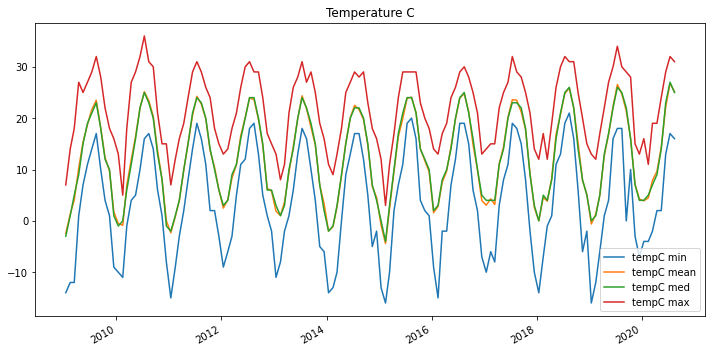

In [41]:
ax = df[["tempC min", "tempC mean", "tempC med", "tempC max"]].plot(figsize=(12, 6), title="Temperature C")
ax.set(xlabel="");

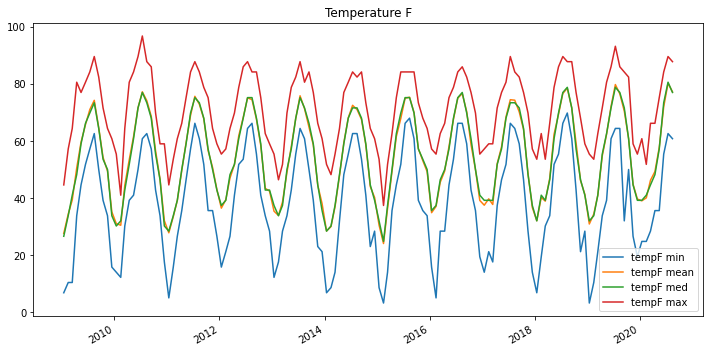

In [42]:
ax = df[["tempF min", "tempF mean", "tempF med", "tempF max"]].plot(figsize=(12, 6), title="Temperature F")
ax.set(xlabel="");

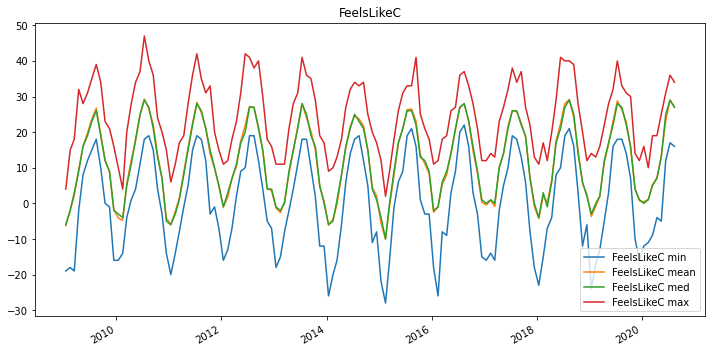

In [43]:
ax = df[["FeelsLikeC min", "FeelsLikeC mean", "FeelsLikeC med", "FeelsLikeC max"]].plot(figsize=(12, 6), title="FeelsLikeC")
ax.set(xlabel="");

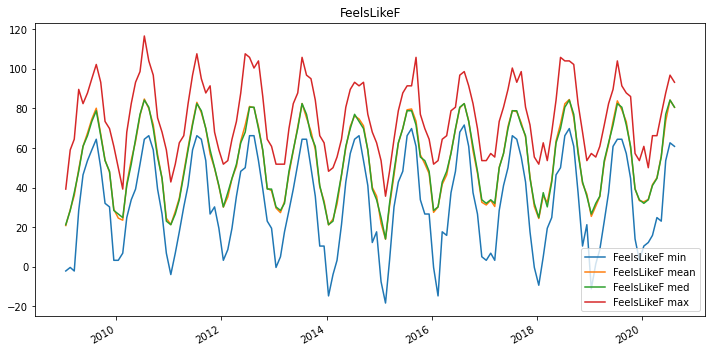

In [44]:
ax = df[["FeelsLikeF min", "FeelsLikeF mean", "FeelsLikeF med", "FeelsLikeF max"]].plot(figsize=(12, 6), title="FeelsLikeF")
ax.set(xlabel="");

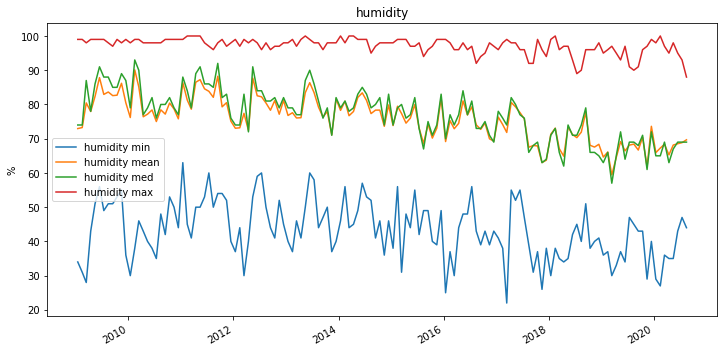

In [45]:
ax = df[["humidity min", "humidity mean", "humidity med", "humidity max"]].plot(figsize=(12, 6), title="humidity")
ax.set(xlabel="", ylabel="%");

[Text(0, 0.5, '%'), Text(0.5, 0, '')]

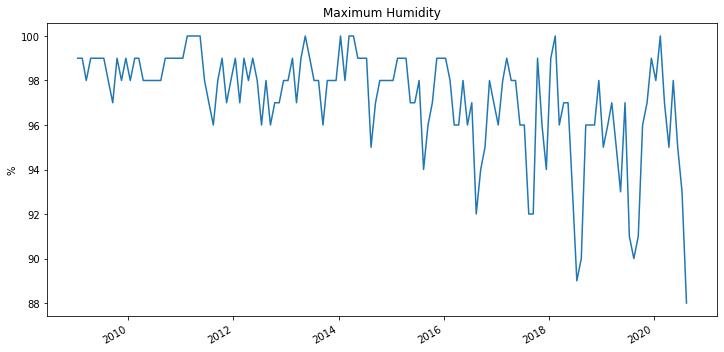

In [46]:
ax = df["humidity max"].plot(figsize=(12, 6), title="Maximum Humidity")
ax.set(xlabel="", ylabel="%")

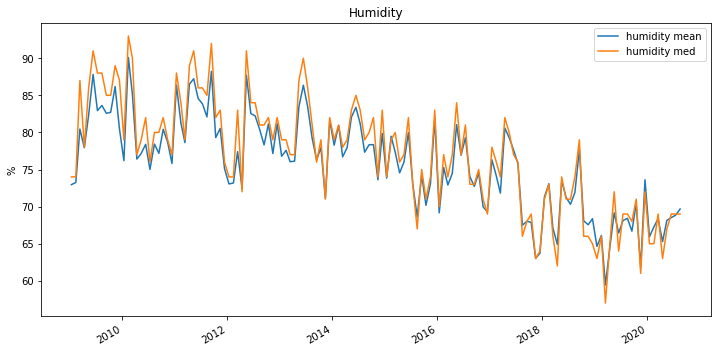

In [47]:
ax = df[["humidity mean", "humidity med"]].plot(figsize=(12, 6), title="Humidity")
ax.set(xlabel="", ylabel="%");

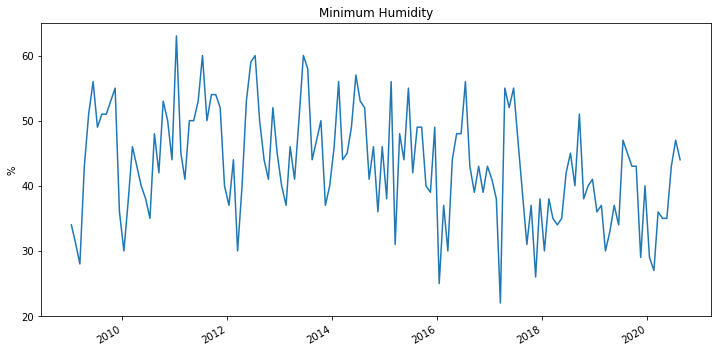

In [48]:
ax = df["humidity min"].plot(figsize=(12, 6), title="Minimum Humidity")
ax.set(xlabel="", ylabel="%");

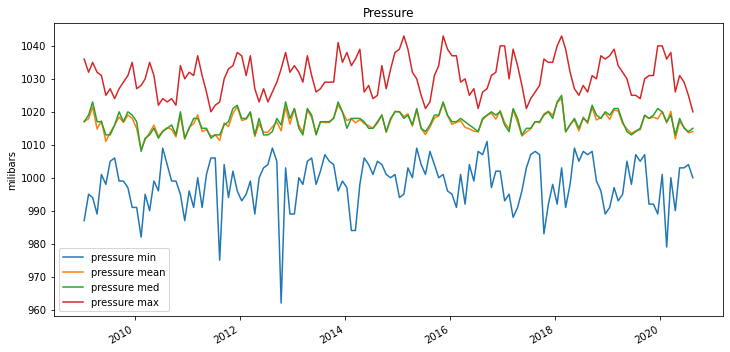

In [49]:
ax = df[["pressure min", "pressure mean", "pressure med", "pressure max"]].plot(figsize=(12, 6), title="Pressure")
ax.set(xlabel="", ylabel="milibars");

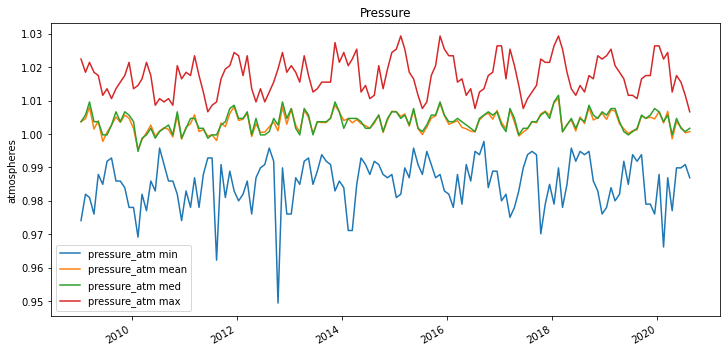

In [50]:
ax = df[["pressure_atm min", "pressure_atm mean", "pressure_atm med", "pressure_atm max"]].plot(figsize=(12, 6),
                                                                                                title="Pressure")

ax.set(xlabel="", ylabel="atmospheres");

## Plotly

In [64]:
import plotly.express as px

fig = px.line(df, x=df.index, y="tempC mean")
fig.show()

In [65]:
df.keys()

Index(['tempC mean', 'tempC min', 'tempC med', 'tempC max', 'tempF mean',
       'tempF min', 'tempF med', 'tempF max', 'FeelsLikeC mean',
       'FeelsLikeC min', 'FeelsLikeC med', 'FeelsLikeC max', 'FeelsLikeF mean',
       'FeelsLikeF min', 'FeelsLikeF med', 'FeelsLikeF max', 'humidity mean',
       'humidity min', 'humidity med', 'humidity max', 'pressure mean',
       'pressure min', 'pressure med', 'pressure max', 'pressure_atm mean',
       'pressure_atm min', 'pressure_atm med', 'pressure_atm max'],
      dtype='object')

In [84]:
csv_files = [file for file in os.listdir(os.path.join("..", "data", "weather")) if file[-3:]  == "csv"]
print9csv_files

['albuquerque_nm.csv',
 'anchorage_ak.csv',
 'annapolis_md.csv',
 'atlanta_ga.csv',
 'augusta_ga.csv',
 'aurora_il.csv',
 'austin_tx.csv',
 'baltimore_md.csv',
 'bandon_or.csv',
 'baton_rouge_la.csv',
 'bethlehem_pa.csv',
 'biloxi_ms.csv',
 'boston_ma.csv',
 'buffalo_ny.csv',
 'charleston_wv.csv',
 'chicago_il.csv',
 'colorado_springs_co.csv',
 'columbia_sc.csv',
 'dallas_tx.csv',
 'denver_co.csv',
 'dover_de.csv',
 'durham_nc.csv',
 'fort_smith_ar.csv',
 'fort_wayne_in.csv',
 'hempstead_ny.csv',
 'houston_tx.csv',
 'huntington_wv.csv',
 'indianapolis_in.csv',
 'jacksonville_fl.csv',
 'jackson_ms.csv',
 'jersey_city_nj.csv',
 'kenmore_wa.csv',
 'knoxville_tn.csv',
 'las_cruces_nm.csv',
 'las_vegas_nv.csv',
 'lexington_ky.csv',
 'little_rock_ar.csv',
 'los_angeles_ca.csv',
 'louisville_ky.csv',
 'memphis_tn.csv',
 'miami_fl.csv',
 'mobile_al.csv',
 'montgomery_al.csv',
 'myrtle_beach_sc.csv',
 'nashville_tn.csv',
 'newark_nj.csv',
 'new_orleans_la.csv',
 'new_york_ny.csv',
 'norfolk_va.

In [ ]:
def histweather(city, metric, stat):
    """
    Visualize a metric over time for a given country.

    Returns JSON to be rendered with Plotly.js by the Web frontend.
    """
    fig = px.line(df, x=df.index, y=f"{metric} {stat}", title=f'{metric}')
    return fig.to_json()

In [53]:
def histweather(city, metric, stat):
    """
    Visualize a metric over time for a given country.

    Returns JSON to be rendered with Plotly.js by the Web frontend.
    """
    fig = px.line(df, x=df.index, y=f"{metric} {stat}", title=f'{metric}')
    return fig.to_json()

In [55]:
histweather("tempC", "mean")

'{"data":[{"hovertemplate":"month=%{x}<br>tempC mean=%{y}<extra></extra>","legendgroup":"","line":{"color":"#636efa","dash":"solid"},"mode":"lines","name":"","orientation":"v","showlegend":false,"type":"scatter","x":["2009-01-15T00:00:00","2009-02-15T00:00:00","2009-03-15T00:00:00","2009-04-15T00:00:00","2009-05-15T00:00:00","2009-06-15T00:00:00","2009-07-15T00:00:00","2009-08-15T00:00:00","2009-09-15T00:00:00","2009-10-15T00:00:00","2009-11-15T00:00:00","2009-12-15T00:00:00","2010-01-15T00:00:00","2010-02-15T00:00:00","2010-03-15T00:00:00","2010-04-15T00:00:00","2010-05-15T00:00:00","2010-06-15T00:00:00","2010-07-15T00:00:00","2010-08-15T00:00:00","2010-09-15T00:00:00","2010-10-15T00:00:00","2010-11-15T00:00:00","2010-12-15T00:00:00","2011-01-15T00:00:00","2011-02-15T00:00:00","2011-03-15T00:00:00","2011-04-15T00:00:00","2011-05-15T00:00:00","2011-06-15T00:00:00","2011-07-15T00:00:00","2011-08-15T00:00:00","2011-09-15T00:00:00","2011-10-15T00:00:00","2011-11-15T00:00:00","2011-12-15T0

In [52]:
!pip install fastapi nest-asyncio pyngrok uvicorn

In [53]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import plotly.express as px

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

@app.get('/')
async def root():
    return {'hello': 'world'}

@app.get('/histweather')
async def histweather(metric):
    """
    Visualize a metric over time for a given country.

    Returns JSON to be rendered with Plotly.js by the Web frontend.
    """
    fig = px.line(df, x=df.index, y=metric, title=f'{metric}')
    return fig.to_json()

In [ ]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn

url = ngrok.connect(port=8000)
print('Public URL:', url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

INFO:     Started server process [4940]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Public URL: http://de96f94c2066.ngrok.io
INFO:     127.0.0.1:53928 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:53929 - "GET /metric%3DtempC?stat=mean HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:53934 - "GET /metric%3D%22tempC%22?stat=%22mean%22 HTTP/1.1" 404 Not Found


In [382]:
df.index = pd.DatetimeIndex(df.index).to_period('M')
df.index

PeriodIndex(['2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06',
             '2009-07', '2009-08', '2009-09', '2009-10',
             ...
             '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04',
             '2020-05', '2020-06', '2020-07', '2020-08'],
            dtype='period[M]', name='month', length=140, freq='M')

In [387]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = df.iloc[:int(len(df.index) * 0.8)]
test = df.iloc[int(len(df.index) * 0.8) - 1:]

model = ExponentialSmoothing(train["tempC mean"], trend="add", seasonal="add",  seasonal_periods=12).fit()
predictions = model.forecast(26)

predictions

2018-05    15.217827
2018-06    19.988181
2018-07    23.519593
2018-08    23.062520
2018-09    19.803308
2018-10    14.347019
2018-11     8.623057
2018-12     4.022867
2019-01     0.036724
2019-02     1.199666
2019-03     4.606978
2019-04     9.947593
2019-05    15.314791
2019-06    20.085145
2019-07    23.616557
2019-08    23.159485
2019-09    19.900272
2019-10    14.443983
2019-11     8.720021
2019-12     4.119831
2020-01     0.133688
2020-02     1.296631
2020-03     4.703942
2020-04    10.044557
2020-05    15.411755
2020-06    20.182109
Freq: M, dtype: float64